# Glider Guidance System 2 Data Visualization
Author: Matthew Learn (matt.learn@marine.rutgers.edu)<br><br>
Jupyter Notebook meant for visualizing Glider Guidance System 2 (GGS2) products.

## Parameter Selection
Here is a list of all parameters and what they do:
| variable | data type | valid inputs/format | Notes |
|---|---|---|---|
| date | string | "YYYY-MM-DD" | Sample date |
| depth | int | 0 - 1000 (recommended) | Maximum working depth (m) of glider model |
| lat_min | float | -85 - 85 | Southern latitude bound |
| lon_min | float | -180 - 180 | Western longitude bound |
| lat_max | float | -85 - 85 | Northern latitude bound |
| lon_max | float | -180 - 180 | Eastern longitude bound |
| CMEMS_ | boolean | True - False | European Model |
| ESPC_ | boolean | True - False | Navy Model |
| RTOFS_EAST_ | boolean | True - False | NOAA model for US east coast |
| RTOFS_WEST_ | boolean | True - False | NOAA model for US west coast |
| RTOFS_PARALLEL_ | boolean | True - False | Experimental NOAA model for east coast |
| COMPUTE_OPTIMAL_PATH | boolean | True - False | Compute the optimal path using an A* algorithm |
| waypoints | list(tuple) | [(lat1, lon1), ..., (latx, lonx)] | List of coordinates to pass into the A* algorithm. Minimum of 2 points are required |
| glider_raw_speed | float | --- | Raw speed of glider model |
| INDIVIDUAL_PLOTS | boolean | True - False | Make plots of individual model products |
| SIMPLE_MEAN | boolean | True - False | Calculate the simple mean of all selected model combinations and plot |
| MEAN_DIFFERENCES | boolean | True - False | Calculate the mean of the differences of each non-repeating pair of models |
| RMSD | boolean | True - False | Calculate the root mean square difference between all selected model combinations and plot |
| make_magnitude_plot | boolean | True - False | Make a plot of depth averaged current magnitude contours |
| make_threshold_plot | boolean | True - False | Make a plot of depth averaged current magnitude threshold contours |
| vector_type | string | "quiver", "streamplot", None | Determines the vector type of the plot to show current direction |
| density | int | --- | Density of streamlines. Higher number = denser streamlines |
| scalar | int | --- | Downsampling scalar for quiver plots. Higher number = Less quivers |
| save | boolean | True - False | Save figures locally in the GGS/figures directory |

In the cell below, parameters may be selected. To run the GGS, click the __two triangles__ on the ribbon at the top of the page. For those using VS Code, it will be the `Run All` button.

In [1]:
date = "2025-02-04"
depth = 1000
lat_min = 34
lon_min = -79
lat_max = 45
lon_max = -50

CMEMS_ = True
ESPC_ = True
RTOFS_EAST_ = True
RTOFS_WEST_ = False
RTOFS_PARALLEL_ = True

COMPUTE_OPTIMAL_PATH = False
waypoints = [(41.240, -70.958), (37.992, -71.248), (36.943, -66.862), (38.666, -62.978), (39.801, -60.653), (39.618, -55.87)]
glider_raw_speed = 0.5

INDIVIDUAL_PLOTS = False
SIMPLE_MEAN = False
MEAN_DIFFERENCES = True
RMSD = False

make_magnitude_plot = True
make_threshold_plot = True

vector_type = 'streamplot'
density = 5
scalar = 6

save = False

## Model and secondary parameter initialization

In [2]:
# imports
from models import *
from functions import *
from pathfinding import *
from plotting import *

import itertools

In [3]:
# intitialization
dates = (date, date)
extent = (lat_min, lon_min, lat_max, lon_max)

cmems = CMEMS()
espc = ESPC()
rtofs_e = RTOFS()
rtofs_w = RTOFS()
rtofs_p = RTOFS()

model_select_dict = {
    cmems: CMEMS_,
    espc: ESPC_,
    rtofs_e: RTOFS_EAST_,
    rtofs_w: RTOFS_WEST_,
    rtofs_p: RTOFS_PARALLEL_,
}
model_list = [model for model, selected in model_select_dict.items() if selected]

optimal_paths = {}

contour_select_dict = {
    'magnitude': make_magnitude_plot,
    'threshold': make_threshold_plot,
}
contour_type = [contour for contour, selected in contour_select_dict.items() if selected]

## Model processing and visualization
Figures will be visualized at the bottom of the page. If the `save` parameter was set to `True`, the figures will also all be saved locally to the `GGS/figures` directory.

In [4]:
try:
    temp = CMEMS()
    temp.load(diag_text=False)
    temp.raw_data.attrs["text_name"] = "COMMON GRID"
    temp.raw_data.attrs["model_name"] = "COMMON_GRID"
    today = datetime.today().strftime("%Y-%m-%d")
    temp.subset((today, today), extent, depth, diag_text=False)
except Exception as e:
    print(f"ERROR: Failed to process CMEMS COMMON GRID data due to: {e}\n")
    print("Processing ESPC COMMON GRID instead...")

    temp = ESPC()
    temp.load(diag_text=False)
    temp.raw_data.attrs["text_name"] = "COMMON GRID"
    temp.raw_data.attrs["model_name"] = "COMMON_GRID"
    today = datetime.today().strftime("%Y-%m-%d")
    temp.subset((today, today), extent, depth, diag_text=False)

COMMON_GRID = temp.subset_data

for model in model_list:
    try:
        if isinstance(model, RTOFS):
            rtofs_sources = {rtofs_e: "east", rtofs_w: "west", rtofs_p: "parallel"}
            source = rtofs_sources[model]
            model.load(source)
        else:
            model.load()

        model.subset(dates, extent, depth)  # subset
        model.subset_data = regrid_ds(model.subset_data.isel(time=0), COMMON_GRID)
        model.z_interpolated_data = interpolate_depth(model, depth)
        model.da_data = depth_average(model)
        model.da_data = calculate_magnitude(model)

        if COMPUTE_OPTIMAL_PATH:
            optimal_paths[model] = compute_a_star_path(waypoints, model, glider_raw_speed)
        else:
            optimal_paths[model] = None
            waypoints = None

        if INDIVIDUAL_PLOTS:
            if "magnitude" in contour_type:
                create_map(model.da_data, extent, "magnitude", vector_type, density, scalar, optimal_paths[model], waypoints, save=save)
            if "threshold" in contour_type:
                create_map(model.da_data, extent, "threshold", vector_type, density, scalar, optimal_paths[model], waypoints, save=save)
    except Exception as e:
        print(f"ERROR: Failed to process {model.raw_data.attrs['text_name']} data due to: {e}\n")
        continue

INFO - 2025-02-04T17:10:35Z - Selected dataset version: "202406"
INFO - 2025-02-04T17:10:35Z - Selected dataset part: "default"


Loading CMEMS data...
Start time (UTC): 2025-02-04 17:10:45.760574+00:00


INFO - 2025-02-04T17:10:46Z - Selected dataset version: "202406"
INFO - 2025-02-04T17:10:46Z - Selected dataset part: "default"


Done.
End time (UTC): 2025-02-04 17:10:56.837085+00:00
Runtime: 0:00:11.076511

CMEMS: Subsetted data.

CMEMS: Regridding to COMMON GRID...
Start time (UTC): 2025-02-04 17:10:56.858078+00:00
Done.
End time (UTC): 2025-02-04 17:11:00.300157+00:00
Runtime: 0:00:03.442079

CMEMS: Interpolating depth...
Start time (UTC): 2025-02-04 17:11:00.300157+00:00
Done.
End time (UTC): 2025-02-04 17:15:17.686516+00:00
Runtime: 0:04:17.386359

CMEMS: Depth averaging...
Start time (UTC): 2025-02-04 17:15:17.727364+00:00
Done.
End time (UTC): 2025-02-04 17:15:17.731197+00:00
Runtime: 0:00:00.003833

CMEMS: Calculating magnitude...
Start time (UTC): 2025-02-04 17:15:17.731197+00:00
Done.
End time (UTC): 2025-02-04 17:15:17.739987+00:00
Runtime: 0:00:00.008790

Loading ESPC data...
Start time (UTC): 2025-02-04 17:15:17.739987+00:00
Done.
End time (UTC): 2025-02-04 17:15:18.174492+00:00
Runtime: 0:00:00.434505

ESPC: Subsetted data.

ESPC: Regridding to COMMON GRID...
Start time (UTC): 2025-02-04 17:15:18.

In [5]:
if SIMPLE_MEAN:
    simple_mean = calculate_simple_mean(model_list)
    if "magnitude" in contour_type:
        create_map(simple_mean, extent, 'magnitude', vector_type, density, scalar, optimized_path=None, waypoints=None, save=save)
    if "threshold" in contour_type:
        create_map(simple_mean, extent, 'threshold', vector_type, density, scalar, optimized_path=None, waypoints=None, save=save)

Mean Difference [CMEMS, ESPC, RTOFS (East Coast), RTOFS (Parallel)]: Creating vectorless plot of depth averaged current mean differences...
Start time (UTC): 2025-02-04 17:15:51.968750+00:00
Done.
End time (UTC): 2025-02-04 17:15:57.019074+00:00
Runtime: 0:00:05.050324



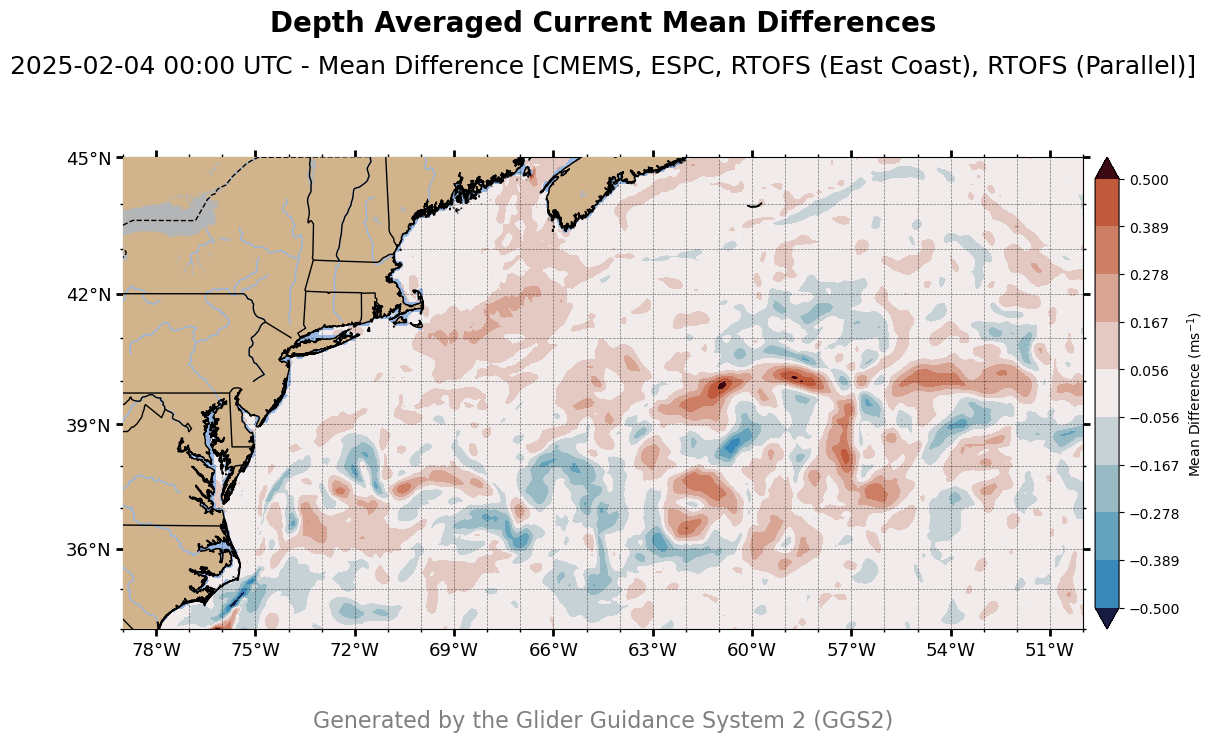

In [6]:
if MEAN_DIFFERENCES:
    try:
        mean_diff = calculate_mean_diff(model_list)
        create_map(mean_diff, extent, "mean_diff", None, density, scalar, save=save)
    except Exception as e:
        print(f"ERROR: Failed to calculate mean differences due to: {e}\n")

In [7]:
if RMSD:
    try:
        model_combos = list(itertools.combinations(model_list, r=2))
        rmsd_list = []
        for model1, model2 in model_combos:
            rmsd = calculate_rmsd(model1, model2)
            rmsd_list.append(rmsd)
            create_map(rmsd, extent, "rmsd", None, density, scalar, save=save)
    except Exception as e:
        print(f"ERROR: Failed to calculate RMSD due to: {e}\n")